# **All Analyses**
This notebook contains the components for the quantitative analysis of the data and model (output)s

1.   Subword-tokenization inspection
2.   Generation Properties
3.   Selection Properties



## 0. Installations

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install torch
!pip install spacy

import transformers
import torch
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import nltk
import spacy
import scipy
import numpy as np

import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForMaskedLM
from collections import Counter, defaultdict

from nltk.corpus import stopwords
nltk.download('stopwords')

!python -m spacy download en_core_web_sm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 27.7 MB/s 
     |████████████████████████████████| 596 kB 39.9 MB/s 
     |████████████████████████████████| 101 kB 10.3 MB/s 
     |████████████████████████████████| 6.6 MB 43.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 11.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 18.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import seaborn as sns

In [3]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 4.9 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3142746 sha256=5df4cbfdc96c0fb4fca73667ed065a3f20d975121b20668e6b709be34cca83b8
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [4]:
nlp=spacy.load('en_core_web_sm')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Subword Tokenization

### Functions

In [ ]:
def get_tokens(file_path, bench=False):
  all_annos =[]
  complex_words = []

  if bench:
    with open(file_path, 'r',encoding="utf-8") as infile:
      data = infile.readlines()

  else: 
    with open(file_path, 'r',encoding="utf-8") as infile:
      data = infile.readlines()

  print("dataset of size:", len(data)) 
  for row in data:
    row = row.strip()
    info = row.split("\t")

    complex_word = info[1]
    complex_words.append(complex_word)
    annotations = info[3:]
    
    if bench:
      clean_annotations = [anno.split(":")[1] for anno in annotations]
    
    else: 
      clean_annotations = annotations

    for a in clean_annotations:
      all_annos.append(a)

  all_annos = list(set(all_annos)  )
  return all_annos, complex_words

In [ ]:
def relative_subwords (abs_subwords):
  relative_dict = dict()
  
  total = sum(abs_subwords.values())
  
  for len, freq in abs_subwords.items():
    relative_dict[len] = (freq/total)*100
  
  return relative_dict


In [ ]:
def count_subwordtokenization(tokenizer, words):
  with open ("subwors.txt","w") as outfile:
    tokenize_sizes = defaultdict(int)
    for word in words:
      # print(word)
      tokenized_word = tokenizer.tokenize(word)
      nr_of_subwords = len(tokenized_word)

      outfile.write(str(tokenized_word)+"\t"+str(nr_of_subwords)+"\n")

      if nr_of_subwords>1:
        print(tokenized_word)


      if nr_of_subwords in tokenize_sizes.keys():
        tokenize_sizes[nr_of_subwords]+=1
      else:
        tokenize_sizes[nr_of_subwords]=1
    
    relative = relative_subwords (tokenize_sizes)

  return dict(tokenize_sizes), relative

### Running analysis

In [ ]:
# Choose Tokenizer
# tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking")
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")

In [ ]:
# Choose file for analysis

# data_files = ["/content/BenchLS.txt", "/content/lex.mturk.txt","/content/NNSeval.txt"]
# data_files = "/content/dutch_sents_for_annotation.txt"]
data_files = ["/content/dutch-data.tsv"]

with open(f"tokenization_analysis.txt", "w") as outfile:

  for file in data_files:
    dataset = file.replace("/content/","")
    print(dataset)

    if "Bench" in file or "NNSeval" in file:
      annotations, complex_words = get_tokens(file, bench=True)
      print(annotations[:5])
      print(complex_words[:5])

    else: 
      annotations, complex_words = get_tokens(file, bench=False)
      print(annotations[:5])
      print(complex_words[:5])

    abs_annos, rel_annos = count_subwordtokenization(tokenizer, annotations)
    abs_cword, rel_cword = count_subwordtokenization(tokenizer, complex_words)

    print("percentage of subword tokenized complex words:",100-rel_cword[1])
    print("percentage of subword tokenized annotation: ",100-rel_annos[1])
    print(abs_cword, abs_annos)

    outfile.write(f"""{dataset}
    Complex Words: 
    \t Absolute \t {abs_cword}
    \t Relative \t {rel_cword}
    \t percentage subword-tokenized \t {100-rel_cword[1]}
    Annotations:
    \t Absolute \t {abs_annos} 
    \t Relative \t {rel_annos}
    \t percentage subword-tokenized \t {100-rel_annos[1]}
    """)

dutch-data.tsv
dataset of size: 95
['straffen', 'opgenomen', 'verdrag', 'hulp', 'volgende']
['middels', 'fungeert', 'opgave', 'uitgezet', 'momenteel']
['kort', '##geleden']
['onafhankelijk', '##heid']
['verandering', '##en']
['door', '##werken']
['beboet', '##en']
['duwt', '##je']
['omzet', '##ting']
['uitstel', '##len']
['eerder', '##e']
['blijven', '##d']
['beslissen', '##d']
['vers', '##i', '##mpel', '##en']
['ingewikkeld', '##heid']
['inge', '##wi', '##kel', '##dheid']
['samen', '##voeg', '##en']
['middel', '##s']
['fungeer', '##t']
['gere', '##fer', '##eerd']
['weder', '##om']
['verblijf', '##s', '##kwaliteit']
['categorie', '##ën']
['over', '##head']
['voor', '##liggende']
['ver', '##taal', '##slag']
['om', '##trent']
['structuree', '##l']
['zelf', '##red', '##zaamheid']
['ref', '##lect', '##eren']
['Hoe', '##wel']
['ge', '##ï', '##m', '##ple', '##ment', '##eerd']
['be', '##ziet']
['flank', '##erend']
['crucia', '##al']
['kick', '-', 'off']
['tempo', '##ris', '##eren']
['ge', '##

## 2. Generation Comparison

### Loading and opening files

In [ ]:
# opening Dutch freq file
with open ("/content/dutch_frequencies.txt", "r") as infile:
  data = infile.readlines()

freq_dict = dict()
for line in data:
  line = line.strip()
  info = line.split("\t")
  word = str(info[0])
  freq = int(info[1])
  freq_dict[word] = freq

In [6]:
# Opening the frequency file, and storing it in a dictionary
freq_dict = dict()

with open ("/content/frequency_merge_wiki_child.txt", "r") as infile:
  data = infile.readlines()

for line in data:
  line = line.strip()
  info = line.split(" ")
  word = info [0]
  freq = int(info [1])
  freq_dict[word]=freq


In [20]:
def open_data(language):
  if language =="en":
    with open ("/content/lex.mturk.txt","r",encoding="ISO-8859-1") as infile:
      data = infile.readlines()[1:]
  # elif language == "nl":
  #   with open ("/content/dutch-data.tsv","r",encoding="UTF-8") as infile:
  #     data = infile.readlines()

    annotations = []
    sentences = []
    cwords = []
    for line in data:
      info = line.strip().split("\t")
      sentence = info[0]
      cword = info[1]
      line_annotations = [] 
      for an in  info[2:]:
        if an.count(" ")<1:
          line_annotations.append(an)
      annotations.append(set(line_annotations))
      sentences.append(sentence)
      cwords.append(cword)

  return annotations, sentences, cwords

### Functions

In [16]:
def get_characteristics(row):
  row = row.strip().split("\t")
  sentence = row[0]
  complex_word = row[1]
  options = set(row[2:])
  
  return(sentence, complex_word, options)

In [17]:
def get_comparisons(base_model, other_model, annotations):
  prediction_dict = defaultdict(list)

  for base_line, model_line, annotations_line in zip(base_model, other_model, annotations):
    if len(base_line)>3:
      sent, complex_word, base_options = get_characteristics(base_line)
    else: continue
    if len(model_line)>3:
      sent, complex_word, model_options = get_characteristics(model_line)
    else: continue
    
    prediction_dict["all_model_preds"].append(model_options)
    prediction_dict["all_base_preds"].append(base_options)

    prediction_dict["ABM"].append(base_options.intersection(model_options, annotations_line))
    prediction_dict["AM"].append(annotations_line.intersection(model_options).difference(base_options))
    prediction_dict["AB"].append(annotations_line.intersection(base_options).difference(model_options))
    prediction_dict["BM"].append(base_options.intersection(model_options).difference(annotations_line))
    prediction_dict["A"].append(annotations_line.difference(base_options, model_options))
    prediction_dict["B"].append(base_options.difference(model_options, annotations_line))
    prediction_dict["M"].append(model_options.difference(base_options, annotations_line))

    prediction_dict["all_preds"] = base_options.union(model_options, annotations_line)
    
  return prediction_dict

In [18]:
def get_frequencies(words):
  # word_list = words
  word_list = [item for wordset in words for item in wordset]
  total_freq = 0
  frequencies = []
  for word in word_list:
    if word in freq_dict.keys():
      # print(word)
      freq = freq_dict[word]
      total_freq += freq
      frequencies.append(freq)
  
  return(frequencies)

In [19]:
def get_pos(sents, cwords):
  complex_poss = [] 
  for sent, cword in zip(sents, cwords):
    print(sent)
    print(cword)
    doc = nlp(sent)
    pos_sequence = []
    tok_sequence = []
    for token in doc:
      pos_sequence.append(token.pos_)
      tok_sequence.append(token.text)
    
    try:
      c_index = tok_sequence.index(cword)
      c_pos = pos_sequence[c_index]
    
    except:
      c_pos = "NONE"
    complex_poss.append(c_pos)
    
  return complex_poss

### Overlap Analysis

In [13]:
from os import listdir
from os.path import isfile, join
# mypath = "/content/ouputs"

# models_to_analyze = ["/content/dutch-data_dutch_FT_1_simple_outputs.txt", "/content/dutch-data_dutch_FT_1_regular_outputs.txt"]

# print(models_to_analyze)
# models_to_analyze = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [22]:
# Open Base Model File:
wwm_path = "/content/LMTWWMoutputs.txt"
# wwm_path = "/content/dutch-data_GroNLPbert-base-dutch-cased_outputs.txt"

with open (wwm_path, "r") as infile:
  base_model = infile.readlines()  

# Open Annotation File
annotations, sentences, cwords = open_data("en")

# Load Stopwords
stop_words = set(stopwords.words('english'))

# List of complex word POSs
# pos_list = get_pos(sentences, cwords)

# List of model outputs to analyze
models_to_analyze = ["/content/lex.mturk_FT_lr5e-06_10000sents_outputs.txt",
                     ] 

In [23]:
with open("generation_analysis.csv","w") as outfile:

  # Write Header
  outfile.write("model_name\tsetting\t occurence\t avg_tok_len\t median\t sigma\t stop_word_count\t stop_word_unique\n")

  # Analysis for each of the model outputs
  for model_to_analyze in models_to_analyze:

    model_name = model_to_analyze.replace("/content/","")
    # model_path = "/content/ouputs/"+model_to_analyze
    model_path = model_name

    with open (model_path, "r") as infile:
      model = infile.readlines()
      comparisons = get_comparisons(base_model, model, annotations)

      for name, setting in comparisons.items():
        print("\nSetting:",name)

        frequencies = get_frequencies(setting)
        occurence = len(frequencies)
        print("This setting occured", occurence, "times")

        # If this setting has at least one overlapping prediction:
        if occurence> 1:
        
          flattened =  [item for wordset in setting for item in wordset]
          lengths = [len(i) for i in flattened]
          
          # Amount of generated stopwords
          stop_word_count = 0  
          for stop_word in stop_words:
            stop_word_count += flattened.count(stop_word)
          stop_word_unique = len(stop_words.intersection(set(flattened)))

          # Frequency statistics
          avg_tok_len = sum(lengths) / len(lengths)
          print(avg_tok_len)
          median = statistics.median(frequencies)
          sigma = statistics.stdev(frequencies)
          
        else:
          stop_word_count = 0
          stop_word_unique = 0
          avg_tok_len = 0
          median = 0
          sigma = 0
        
        outfile.write(model_name+"\t"+
                      name+"\t"+
                      str(occurence)+"\t"+
                      str(avg_tok_len)+"\t"+
                      str(median)+"\t"+
                      str(sigma)+"\t"+
                      str(stop_word_count)+"\t"+
                      str(stop_word_unique)+"\n")



Setting: all_model_preds
This setting occured 5000 times
7.347

Setting: all_base_preds
This setting occured 5000 times
7.485

Setting: ABM
This setting occured 1318 times
6.783004552352049

Setting: AM
This setting occured 356 times
6.297752808988764

Setting: AB
This setting occured 161 times
6.919254658385094

Setting: BM
This setting occured 2148 times
7.827281191806332

Setting: A
This setting occured 3236 times
6.913526146654981

Setting: B
This setting occured 1373 times
7.689730517115805

Setting: M
This setting occured 1178 times
7.419354838709677

Setting: all_preds
This setting occured 110 times
1.0


### Dutch: Analysis of non-word predictions

In [ ]:
with open("/content/drive/MyDrive/Thesis/code/Dutch/Error Analysis/outputs.txt","r") as infile:
  data = infile.readlines()

In [ ]:
print(len(data))
only_chars = [] 
also_chars = []

for row in data:
  info = row.strip().split("\t")
  sentence = info [0]
  cword = info [1]
  predictions = info[2:]
  one_char_preds = len([i for i in predictions if len(i)==1])

  if one_char_preds == 0:
    continue
  elif one_char_preds in range(1,10):
    also_chars.append(row)
    print("less than ten")
    print(sentence, cword, predictions)
  else: 
    only_chars.append(row)
    print("there are ten")
    print(sentence, cword, predictions)

1024
less than ten
De gemeente Amsterdam stimuleert mobiliteit en heeft daarbij ook aandacht voor de mogelijkheden van promotie en demotie. stimuleert ['biedt', 'steunt', 'bevorderd', 'gestimuleerd', 'c', 'l', 'l', 'l', 'l', 'l']
less than ten
prestatie met bijbehorend stimulerend gedrag. stimulerend ['gezond', 'positief', 'prettig', 'aantrekkelijk', 'creatief', 'o', 'l', 'i', 'i', 'i']
less than ten
Geef aandacht aan diversiteit, b.v. door verschillende feestdagen te vieren diversiteit ['cultuur', 'schoonheid', 'innovatie', 'à', 'j', 'j', 'j', 'j', 'j', 'j']
there are ten
Daar kun je het met elkaar over hebben. daar ['m', 'i', 'p', 'k', 'à', 'è', 'è', 'è', 'è', 'è']
less than ten
Ook vervult de monitor een verantwoordingsfunctie. monitor ['bestuurder', 'voorzitter', 'burgemeester', 'directeur', 'werknemer', 'ambtenaar', 'secretaris', 'c', 'c', 'c']
less than ten
van ‘High Impact Crime’ (HIC) die in 2011 in de regio Amsterdam-Amstelland is opgezet. impact ['effect', 't', 'à', 'i', 'y',

In [ ]:
with open ("only_chars.txt","w") as outfile:
  outfile.writelines(only_chars)

with open ("also_chars.txt","w") as outfile:
  outfile.writelines(also_chars)

## Similarity with cword

In [ ]:
import fasttext.util
fasttext.util.download_model('nl', if_exists='ignore')  # English
ft = fasttext.load_model('cc.nl.300.bin')


In [ ]:
def similarity_with_cword(data, length_threshold):

  all_similarities = []
  average_similarities = dict()

  for row in data:
    info = row.strip().split("\t")
    cword = info[1] 
    sent = info [0]
    predictions = info [2:]

    sentence_similarities = []

    for word in predictions: 
      if length_threshold and (len(word)==1 or word == "[UNK]"):
        continue 
      print(word, cword)
      embed = ft.get_word_vector(word)
      c_embed = ft.get_word_vector(cword)
      # print(embed)

      # embed = np(ft[word], axis=0)
      # c_embed = np(ft[cword], axis=0)
      similarity = 1-scipy.spatial.distance.cosine(c_embed, embed)
      print(similarity)
      sentence_similarities.append(similarity)
    
    all_similarities.append(sentence_similarities)
    try:
      average_similarity = sum(sentence_similarities)/len(sentence_similarities)
    except:
      average_similarity = 0
    average_similarities[sent]= average_similarity
  print(sorted( ((v,k) for k,v in average_similarities.items()), reverse=False))

  return average_similarities

Streaminguitvoer ingekort tot de laatste 5000 regels.
0.6010582447052002
analyseren evalueren
0.6253178119659424
controleren evalueren
0.49068570137023926
bestuderen evalueren
0.5238322615623474
vaststellen evalueren
0.5367552638053894
toetsen evalueren
0.43033310770988464
bezien evalueren
0.4334785044193268
onderzoeken evalueren
0.55048668384552
vergelijken evalueren
0.4146403968334198
gemengde gedifferentieerde
0.4247090518474579
betere gedifferentieerde
0.43919309973716736
optimale gedifferentieerde
0.4170815348625183
vaste gedifferentieerde
0.36639660596847534
duidelijke gedifferentieerde
0.4095766544342041
sterke gedifferentieerde
0.3875233829021454
organische gedifferentieerde
0.3645034432411194
stabiele gedifferentieerde
0.3779338598251343
positieve gedifferentieerde
0.3374612331390381
gezonde gedifferentieerde
0.36491551995277405
vergoeding compensatie
0.6350526213645935
gecompenseerd compensatie
0.5865756273269653
steun compensatie
0.42183026671409607
tegemoetkoming compensati

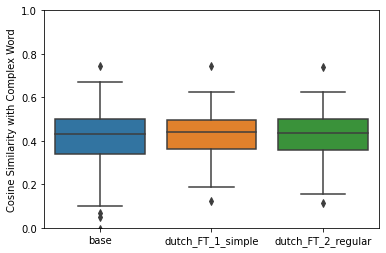

In [ ]:
# one = ft.get_word_vector("xzcvzxvzxcvcxzc")
# two = ft.get_word_vector("xzcvzxvzxcvcxzcv")

# sim = scipy.spatial.distance.cosine(one, two)

# ft.get_nearest_neighbors('leges')

models_to_analyze = ["/content/dutch-data_GroNLPbert-base-dutch-cased_outputs.txt","/content/dutch-data_dutch_FT_1_simple_outputs.txt", "/content/dutch-data_dutch_FT_2_regular_outputs.txt"]

output_dict = dict()

for model in models_to_analyze:
  model_name = model.split("/")[-1].replace("dutch-data_","").replace("_outputs.txt","").replace("GroNLPbert-base-dutch-cased", "base")

  with open (model, "r") as infile:
    data = infile.readlines()
    av_sim_output = similarity_with_cword(data, False)

  outputs = pd.Series(av_sim_output.values())
  outputs.describe()
  output_dict[model_name] = outputs

# df = pd.DataFrame({"Data":list(av_sim_annos.values()), "Outputs":list(av_sim_output.values())})
df = pd.DataFrame(output_dict)
p = sns.boxplot(data = df)
p.set_ylabel ("Cosine Similarity with Complex Word")
plt.ylim(0,1)
plt.show()



In [ ]:


with open ("/content/dutch-data_GroNLPbert-base-dutch-cased_outputs.txt", "r") as infile:
  data = infile.readlines()
  av_sim_output = similarity_with_cword(data, False)

outputs = pd.Series(av_sim_output.values())
outputs.describe()

FileNotFoundError: ignored

In [ ]:
with open ("/content/dutch-data_GroNLPbert-base-dutch-cased_outputs.txt", "r") as infile:
  data = infile.readlines()
  av_sim_output = similarity_with_cword(data, True)

outputs = pd.Series(av_sim_output.values())
outputs.describe()

In [ ]:
with open ("/content/dutch-data.tsv", "r") as infile:
  data = infile.readlines()
  av_sim_annos = similarity_with_cword(data, False) 

datas = pd.Series(av_sim_annos.values())
datas.describe()

met middels
0.5841204524040222
door middels
0.5940938591957092
via middels
0.6962358951568604
geldt fungeert
0.5000826120376587
is fungeert
0.21052390336990356
speelt fungeert
0.5084803104400635
dient fungeert
0.5546553134918213
werkt fungeert
0.5613229870796204
uitdaging opgave
0.4792846143245697
opdracht opgave
0.49025020003318787
uitgangspunt opgave
0.3597700595855713
doel opgave
0.28642410039901733
resultaat opgave
0.34186866879463196
probleem opgave
0.3463209867477417
aangegeven uitgezet
0.5507288575172424
geplaatst uitgezet
0.47466373443603516
gezet uitgezet
0.6146228909492493
opgenomen uitgezet
0.521270751953125
nu momenteel
0.3200618028640747
tegenwoordig momenteel
0.5106290578842163
gedacht gerefereerd
0.38385841250419617
verwezen gerefereerd
0.6893638968467712
gelinkt gerefereerd
0.5124764442443848
herinnerd gerefereerd
0.49454692006111145
nog wederom
0.6389917731285095
weer wederom
0.7153548002243042
alweer wederom
0.6358041763305664
opnieuw wederom
0.6629392504692078
vernie

count    95.000000
mean      0.519804
std       0.128366
min       0.276449
25%       0.425745
50%       0.523606
75%       0.599839
max       0.822765
dtype: float64

In [ ]:
with open ("/content/dutch-data.tsv", "r") as infile:
  data = infile.readlines()
  av_sim_annos = similarity_with_cword(data, True) 

datas = pd.Series(av_sim_annos.values())
datas.describe()

In [ ]:
import pandas as pd
outputs = pd.Series(av_sim_output.values())
outputs.describe()

count    95.000000
mean      0.421959
std       0.136646
min      -0.006769
25%       0.337784
50%       0.433218
75%       0.499869
max       0.743530
dtype: float64

In [ ]:
datas = pd.Series(av_sim_annos.values())
datas.describe()

count    95.000000
mean      0.519804
std       0.128366
min       0.276449
25%       0.425745
50%       0.523606
75%       0.599839
max       0.822765
dtype: float64

(0.0, 1.0)

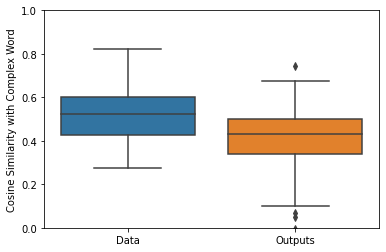

In [ ]:
import seaborn as sns
df = pd.DataFrame({"Data":list(av_sim_annos.values()), "Outputs":list(av_sim_output.values())})

p = sns.boxplot(data = df )
p.set_ylabel ("Cosine Similarity with Complex Word")
plt.ylim(0,1)


## 3. Selection Analysis